In [161]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import scipy.stats as st

## training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [162]:
class GaussianNN(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(GaussianNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.fc2(x)
        mu, log_var = x[:, 0], x[:, 1]
        # mu, log_var = F.relu(x[:, 0]), x[:, 1] 
        # mu = F.softplus(mu)  
        # log_var=F.relu(log_var)
        return mu, torch.exp(log_var)


def gaussian_nll(mu, var, x):
    return 0.5 * (torch.log(2 * torch.pi * var) + (x - mu)**2 / var).mean()

# def gaussian_nll(mu, var, x, w1=1.0, w2=1.0):
#     return 0.5 * (w1 * (x - mu)**2 / var + w2 * torch.log(2 * torch.pi * var)).mean()


def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_preprocess_file(file_path, features, target):
    # Load the data
    df = pd.read_hdf(file_path)
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert data to PyTorch tensors
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    # Reshape to (seq_length, n_features)
    feature_tensors = feature_tensors.view(-1, len(features))

    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)

            
def whiff_mean_concentration(tensor):
    # print(torch.mean(tensor))
    return torch.mean(tensor)

# def train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
        
#         # Flatten the sequences and ensure they are float type
#         flattened_sequences = sequences.view(sequences.size(0), -1).float().to(device)
#         targets = targets.float().to(device)
        
#         mu, var = model(flattened_sequences)
        
#         # Ensure your targets are in the correct shape and type
#         loss = criterion(mu, var, targets.squeeze())
        
#         loss.backward()
#         optimizer.step()
        
#         if (epoch + 1) % 100 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

def train_on_single_file_faster(model, optimizer, scheduler, criterion, sequences, targets, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Flatten the sequences and ensure they are float type
        flattened_sequences = sequences.view(sequences.size(0), -1).float().to(device)
        targets = targets.float().to(device)
        
        mu, var = model(flattened_sequences)
        
        # Ensure your targets are in the correct shape and type
        loss = criterion(mu, var, targets.squeeze())
        
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
    feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    model.eval()
    with torch.no_grad():
        mu, var = model(sequences.view(sequences.size(0), -1))
    mu_preds = mu.cpu().numpy()
    var_preds = var.cpu().numpy()
    return mu_preds, var_preds



In [163]:
# input_size = 2  # Number of input features
# hidden_dim = 128
# num_epochs = 250
# seq_length = 5 
# num_mixtures = 3  # define the number of Gaussian mixtures
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Create the MDN model
# model_mdn = MDN(input_size * seq_length, hidden_dim, num_mixtures).to(device)

# # Define optimizer and loss
# optimizer = optim.Adam(model_mdn.parameters(), lr=0.007)
# criterion = mdn_loss

# features = ['distance_along_streakline','nearest_from_streakline']
# target = ['odor']

# filepath="/home/beast/An/data/Sept13Plumes/plume1/train/"
# for file in os.listdir(filepath):
#     file_path = os.path.join(filepath, file)
    
#     feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
#     sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
#     sequences = sequences.to(device)
#     targets = targets.to(device)
    
#     train_on_single_file_mdn(model_mdn, optimizer, criterion, sequences, targets, num_epochs)

In [188]:
input_size = 2  # Number of input features
hidden_dim = 128
num_epochs = 75
seq_length = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_gaussian = GaussianNN(input_size * seq_length, hidden_dim).to(device)

optimizer = optim.Adam(model_gaussian.parameters(), lr=0.007)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # adjust step_size and gamma as needed
criterion = gaussian_nll

features = ['distance_along_streakline','nearest_from_streakline']
target = ['odor']

filepath="/home/beast/An/data/Sept13Plumes/plume1/train/"
for file in os.listdir(filepath):
    file_path = os.path.join(filepath, file)
    
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    train_on_single_file_faster(model_gaussian, optimizer, scheduler, criterion, sequences, targets, num_epochs)

In [189]:
# def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
#     feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
#     sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
#     sequences = sequences.to(device)
#     model.eval()
#     with torch.no_grad():
#         pi, mu, sigma = model(sequences.view(sequences.size(0), -1))
        
#         # Check for NaN values here
#         if torch.isnan(pi).any() or torch.isnan(mu).any() or torch.isnan(sigma).any():
#             print("NaN value detected during prediction!")
#             # You might handle this in various ways like returning a default value or raising an exception
        
#     mu_preds = mu.cpu().numpy()
#     var_preds = sigma.cpu().numpy()
#     pi_preds = pi.cpu().numpy()
    
#     return mu_preds, var_preds, pi_preds


# fp="/home/beast/An/data/Sept13Plumes/plume1/train/diag11.h5"
# num_samples = 100

# # Load actual targets
# _, actual_targets = load_and_preprocess_file(fp, features, target)

# # Ensure actual_targets is a 1D numpy array
# actual_targets = actual_targets.cpu().numpy().squeeze()

# # Get predictions
# predictions = predict_on_new_data_mdn(model_mdn, fp, features, target, seq_length, device, num_samples)

# # Create a time axis
# time_axis = np.arange(len(actual_targets))

# # Plotting
# f, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(time_axis, actual_targets, label='Actual', color='blue')

# # Plot each predicted sample
# for i in range(num_samples):
#     ax.plot(time_axis[seq_length:], predictions[:, i], label='Predicted Sample', color='red', alpha=0.1)

# ax.set_xlabel('Time')
# ax.set_ylabel('Value')
# ax.set_title('Actual vs Predicted')
# ax.legend()


In [190]:
fp="/home/beast/An/data/Sept13Plumes/plume1/train/diag11.h5"
# fp="/home/beast/An/data/Sept13Plumes/plume1/combined.h5"
mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)


In [191]:
_, actual_targets = load_and_preprocess_file(fp, features, target)

# Ensure actual_targets is a 1D numpy array
actual_targets = actual_targets.cpu().numpy().squeeze()

# Get predictions
mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)

# Create a time axis
time_axis = np.arange(len(actual_targets))


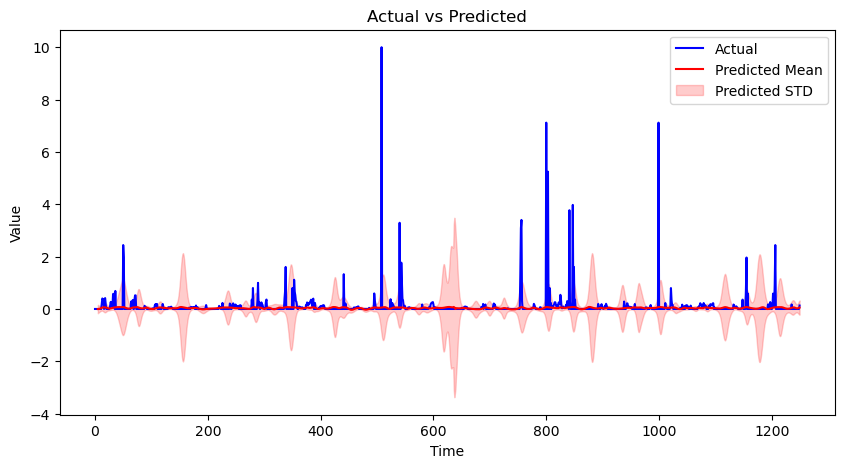

In [192]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(time_axis, actual_targets, label='Actual', color='blue')

ax.plot(time_axis[seq_length:], mu_preds, label='Predicted Mean', color='red')

ax.fill_between(time_axis[seq_length:], 
                mu_preds - np.sqrt(var_preds), 
                mu_preds + np.sqrt(var_preds), 
                color='red', alpha=0.2, label='Predicted STD')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')
ax.legend()

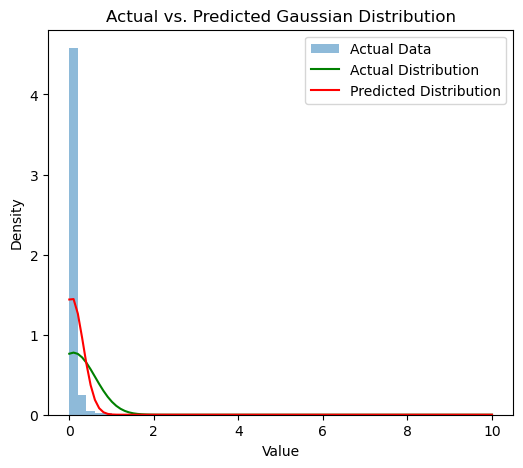

In [193]:
# Ensure predictions are numpy arrays for plotting
mu_preds = mu_preds.squeeze()
var_preds = var_preds.squeeze()

# Select a specific prediction (e.g., the last one)
selected_mu_pred = mu_preds[-1]
selected_var_pred = var_preds[-1]

# Generate a grid of values
x_vals = np.linspace(min(actual_targets), max(actual_targets), 100)

# Calculate the actual mean and variance of your target data
actual_mu = np.mean(actual_targets)
actual_var = np.var(actual_targets)

# Generate the Gaussian distributions
predicted_dist = (1 / (np.sqrt(2 * np.pi * selected_var_pred))) * np.exp(- (x_vals - selected_mu_pred)**2 / (2 * selected_var_pred))
actual_dist = (1 / (np.sqrt(2 * np.pi * actual_var))) * np.exp(- (x_vals - actual_mu)**2 / (2 * actual_var))

# Plotting using subplots style
f, ax = plt.subplots(1, 1, figsize=(6, 5))

# Histogram of actual targets
ax.hist(actual_targets, bins=50, density=True, alpha=0.5, label="Actual Data")

# Actual and predicted Gaussian distributions
ax.plot(x_vals, actual_dist, 'g', label="Actual Distribution")
ax.plot(x_vals, predicted_dist, 'r', label="Predicted Distribution")

ax.set_title("Actual vs. Predicted Gaussian Distribution")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.legend()


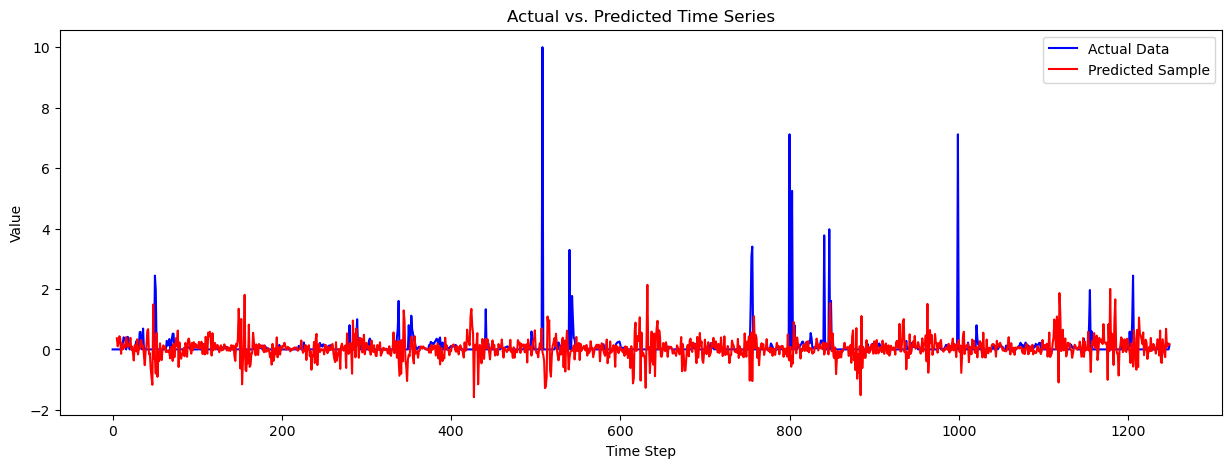

In [181]:
np.random.seed(0)  # for reproducibility
predicted_sample = np.random.normal(mu_preds, np.sqrt(var_preds))

# Plotting using subplots style
f, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plotting the actual targets and predicted sample
ax.plot(actual_targets, 'b', label="Actual Data")
ax.plot(np.arange(seq_length, seq_length+len(predicted_sample)), 
        predicted_sample, 'r', label="Predicted Sample")

# Shading the predicted standard deviation
# ax.fill_between(np.arange(seq_length, seq_length+len(predicted_sample)), 
#                 mu_preds - np.sqrt(var_preds), 
#                 mu_preds + np.sqrt(var_preds), 
#                 color='red', alpha=0.2, label='Predicted STD')

ax.set_title("Actual vs. Predicted Time Series")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")
ax.legend()

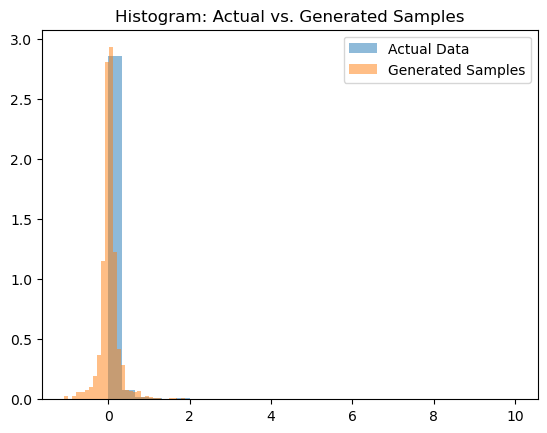

In [170]:
# Histogram
plt.hist(actual_targets[seq_length:], bins=30, alpha=0.5, label="Actual Data", density=True)
plt.hist(predicted_sample, bins=30, alpha=0.5, label="Generated Samples", density=True)
plt.legend()
plt.title("Histogram: Actual vs. Generated Samples")
plt.show()


In [142]:
predicted_sample_padded = np.pad(predicted_sample, (0, 5), 'constant', constant_values=(0))
df = pd.read_hdf(fp)
df['predicted_sample'] = predicted_sample_padded

In [143]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>1'
df1 = df.query(query)
df1.reset_index(drop=True, inplace=True)

query1='predicted_sample>1'
df2 = df.query(query1)
df2.reset_index(drop=True, inplace=True)


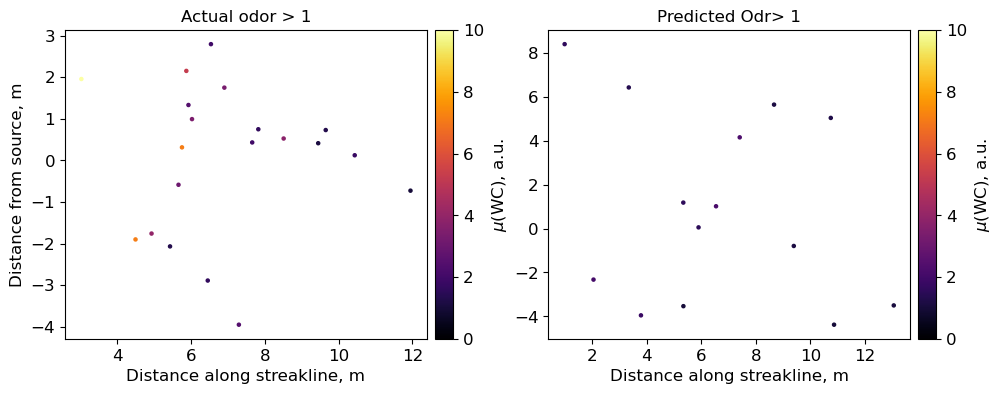

In [144]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.odor, 
             s=5, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Actual odor > 1')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df2.distance_along_streakline, df2.nearest_from_streakline, c=df2.predicted_sample, 
             s=5, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr> 1')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

In [ ]:
## not the best idea to train on multiple plumes at once

# input_size = 2  # Number of input features
# hidden_dim = 128
# num_epochs = 250
# seq_length = 5 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_gaussian = GaussianNN(input_size * seq_length, hidden_dim).to(device)

# optimizer = optim.Adam(model_gaussian.parameters(), lr=0.009)
# criterion = gaussian_nll

# features = ['distance_along_streakline','nearest_from_streakline']
# target = ['odor']

# # Iterate over each plume folder
# for plume_folder in ['plume1', 'plume3', 'plume4']:
#     filepath = f"/home/beast/An/data/Sept13Plumes/{plume_folder}/train/"
#     for file in os.listdir(filepath):
#         file_path = os.path.join(filepath, file)

#         feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
#         sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
        
#         sequences = sequences.to(device)
#         targets = targets.to(device)
        
#         train_on_single_file_faster(model_gaussian, optimizer, criterion, sequences, targets, num_epochs)



# class MDN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_mixtures):
#         super(MDN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.pi = nn.Linear(hidden_dim, num_mixtures)
#         self.mu = nn.Linear(hidden_dim, num_mixtures)
#         self.sigma = nn.Linear(hidden_dim, num_mixtures)
        
#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))
        
#         pi = F.softmax(self.pi(x), dim=1)
        
#         mu = self.mu(x)
#         mu = torch.nan_to_num(mu, nan=0.0, posinf=0.0, neginf=0.0)
        
#         sigma = torch.exp(self.sigma(x))
#         sigma = torch.nan_to_num(sigma, nan=1.0, posinf=1.0, neginf=1.0)  # Ensure standard deviation is positive and not NaN
        
#         return pi, mu, sigma

# def mdn_loss(pi, mu, sigma, y):
#     m = torch.distributions.Normal(loc=mu, scale=sigma)
#     log_prob_y = m.log_prob(y.unsqueeze(-1))
#     log_prob_y = torch.sum(log_prob_y * pi, dim=1)
#     return -torch.mean(torch.log(log_prob_y + 1e-6))

# def train_on_single_file_mdn(model, optimizer, criterion, sequences, targets, num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
        
#         flattened_sequences = sequences.view(sequences.size(0), -1).float().to(device)
#         targets = targets.float().to(device)
        
#         pi, mu, sigma = model(flattened_sequences)
        
#         # Check for NaN values here
#         if torch.isnan(pi).any() or torch.isnan(mu).any() or torch.isnan(sigma).any():
#             print(f"NaN value detected during training at epoch {epoch}!")
#             # You can add a break here to stop training when NaN is detected
#             break
        
#         loss = criterion(pi, mu, sigma, targets.squeeze())
        
#         loss.backward()
#         optimizer.step()
        
#         if (epoch + 1) % 100 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
